In [2]:
import numpy as np
import matplotlib as mpl
import pandas as pd
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons,make_blobs
from sklearn.metrics import accuracy_score

A couple of helper functions we can use:

### Explanation for the covariance matrix:
Let:


variance_x    covariance

covariance    variance_y


The entry in the top left corner represents the variance of variable X. It indicates how much the values of X deviate from their mean. A larger variance suggests greater variability in the values of X.

The entry in the bottom right corner represents the variance of variable Y. It indicates how much the values of Y deviate from their mean. Similarly, a larger variance suggests greater variability in the values of Y.

The entry in the top right corner (or bottom left corner) represents the covariance between X and Y. It measures the degree to which X and Y vary together. If the covariance is positive, it indicates that X and Y tend to increase or decrease together. If the covariance is negative, it suggests that as X increases, Y tends to decrease or vice versa. A covariance of zero implies that X and Y are not linearly related.

In [3]:
def sample_2d_gaussian(meanx,meany,variance_x,variance_y,covariance,numsamps):
    '''
    Generates a random sample of size 'numsamps' from a 2-dimensional Gaussian distribution.
    The Gaussian is defined by the mean vector (meanx,meany) and the 
    covariance matrix
    
    variance_x    covariance
    covariance    variance_y
    
    All parameters can be freely chosen, except covariance, which must satisfy the inequality
    
    covariance <= sqrt(variance_x * variance_y)
    '''
    meanvec = np.array([meanx,meany])
    covarmatrix = np.array([[variance_x,covariance],[covariance,variance_y]])
    return multivariate_normal(meanvec,covarmatrix,numsamps)


def maxpos(A):
    '''
    Takes an n x k array A, and returns 1-dim n array where the i'th
    entry is the index of column in A where the i'th row of A has its
    maximal value (application: turns a probabilitiy distribution over
    k classes for n instances into a single prediction)
    '''
    return np.argmax(A,axis=1)
    

### Part 1: Decision regions for simple 2 dimensional datasets

Loading/generating data: following are several alternative ways to get data consisting of the input features stored in 'features', and the class labels, stored in 'labels'.  Only execute one of the data generating cells, before moving on to the following code!

**A**: sampling data from 2-dimensional Gaussian distributions. For reproducibility, one can fix a random seed.

In [4]:
#np.random.seed(1)
datasize=250
mixturecoeff=np.array([0.4,0.2,0.4])
componentsizes=(datasize*mixturecoeff).astype(int)

# sample_2d_gaussian(meanx,meany,variance_x,variance_y,covariance,numsamps)
class0samp=sample_2d_gaussian(2,3,0.5,0.5,0.45,componentsizes[0])
class1samp=sample_2d_gaussian(5,3,1.0,0.5,-0.45,componentsizes[1])
class2samp=sample_2d_gaussian(3,2,0.5,0.5,0,componentsizes[2])
  
  
features=np.concatenate((class0samp,class1samp,class2samp),axis=0)
labels=np.concatenate((np.zeros(componentsizes[0]),np.ones(componentsizes[1]),2*np.ones(componentsizes[2])))         

**B**: Loading mi.txt data:

In [5]:
midata = pd.read_csv("MI-labeled.txt", sep=',')
features = np.array(midata[['X1','X2']])
classlabels=midata['Class']
labels = np.zeros(len(classlabels))
for i in range(len(classlabels)):
    if classlabels[i] == 'I':
        labels[i]=1

Plotting the data with labels indicated by color:

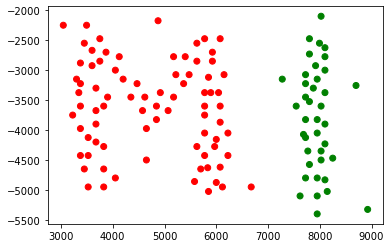

In [6]:
plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b','g']))
plt.show()

Preparing meshgrid for plotting decision regions:

In [7]:
maxvalx = np.max(features[:,0])
maxvaly = np.max(features[:,1])
minvalx = np.min(features[:,0])
minvaly = np.min(features[:,1])

border=5 # zoom in / out: the smaller border is, the more points in the meshgrid
xinterval = (maxvalx-minvalx)/border
yinterval = (maxvaly-minvaly)/border
xx, yy = np.meshgrid(np.arange(minvalx-xinterval, maxvalx+xinterval, xinterval/100), np.arange(minvaly-yinterval, maxvaly+yinterval, yinterval/100))

Learning a classifier -- uncomment to select the classification model to use.

In [8]:
model=LinearDiscriminantAnalysis()
#model = LogisticRegression()
#model = SVC(kernel='linear')

model.fit(features,labels)

LinearDiscriminantAnalysis()

Applying model to the meshgrid. All models return a quantitative "likelihood" for the different classes. For the probabilistic models, these are class label probabilities that are retrieved using the `.predict_proba` method. For the non-probabilistic SVC model, this is the `decision_function` method. In all cases, we classify a datapoint as belonging to the class with the maximal "likelihood" value.

In [9]:
Z=model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
#Z=model.decision_function(np.c_[xx.ravel(), yy.ravel()])
meshclasses = maxpos(Z)
#meshclasses = np.ones(Z.size)
#meshclasses[Z<0]=0
meshclasses = meshclasses.reshape(xx.shape)

In [10]:
model.decision_function(np.c_[xx.ravel(), yy.ravel()])

array([-19.73263926, -19.6848723 , -19.63710534, ...,  15.17905264,
        15.2268196 ,  15.27458657])

Plotting datapoints and decision regions

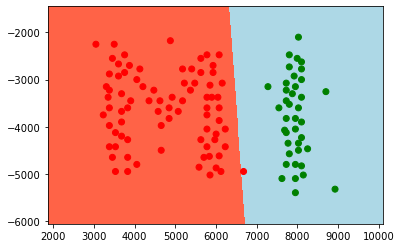

In [11]:
plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b','g']))
#plt.scatter(data[:,0],data[:,1],c=classlabels_numeric, cmap = mpl.colors.ListedColormap(['r', 'b']))
plt.show()

We also calculate the predictions on the (training) datapoints, and check the accuracy:

In [12]:
pred_labels=model.predict(features)
print("Accuracy: {}".format(accuracy_score(labels,pred_labels)))

Accuracy: 0.9915966386554622


**Exercise 1**: Experiment with the three classifiers Linear Discriminant Analysis, Logistic Regression, and linear support vector machines. Use the MI data, and different mixtures of Gaussians you create by varying the parameters in `sample_2d_gaussian'. 

For the Gaussian mixture data:

Create one or several linearly separable Gaussian mixture datasets (can be with only two components) for which some of the models give a perfect separation of the classes, and others don't (this is related to Exercise 4 in self study 1). 

Create separate test sets using the same parameters for the Gaussian mixture as in the creation of the training set. Can you create a test/train dataset and find classifiers A and B, such that A is better than B on the training data, but B is better than A on the test set? Why is this not such an easy task for the datasets and classifiers we consider her?

For the MI data:

explain the structure of the decision regions you find for the different classifiers.


### Gaussian Data

In [13]:
def GenerateData_Gauss(samps, model):
    np.random.seed(1)
    datasize=250
    mixturecoeff=np.array([0.4,0.2,0.4])
    componentsizes=(datasize*mixturecoeff).astype(int)
    
    samp1, samp2, samp3 = samps

    # sample_2d_gaussian(meanx,meany,variance_x,variance_y,covariance,numsamps)
    class0samp=sample_2d_gaussian(*samp1,componentsizes[0])
    class1samp=sample_2d_gaussian(*samp2,componentsizes[1])
    class2samp=sample_2d_gaussian(*samp3,componentsizes[2])

    features=np.concatenate((class0samp,class1samp,class2samp),axis=0)
    labels=np.concatenate((np.zeros(componentsizes[0]),np.ones(componentsizes[1]),2*np.ones(componentsizes[2])))
    
    maxvalx = np.max(features[:,0])
    maxvaly = np.max(features[:,1])
    minvalx = np.min(features[:,0])
    minvaly = np.min(features[:,1])

    border=5 # zoom in / out: the smaller border is, the more points in the meshgrid
    xinterval = (maxvalx-minvalx)/border
    yinterval = (maxvaly-minvaly)/border
    xx, yy = np.meshgrid(np.arange(minvalx-xinterval, maxvalx+xinterval, xinterval/100), np.arange(minvaly-yinterval, maxvaly+yinterval, yinterval/100))

    prevmodel = model
    model.fit(features,labels)
    
    if (prevmodel == LinearDiscriminantAnalysis() or prevmodel == LogisticRegression()):
        
        Z=model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        #Z=model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z=model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        
    meshclasses = maxpos(Z)
    #meshclasses = np.ones(Z.size)
    #meshclasses[Z<0]=0
    meshclasses = meshclasses.reshape(xx.shape)
    
    plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
    plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b','g']))
    #plt.scatter(data[:,0],data[:,1],c=classlabels_numeric, cmap = mpl.colors.ListedColormap(['r', 'b']))
    plt.show()

##### Test model 1
LDA and Logistic Regression don't separate the data, but SVC does.
LDA because covariance matrices, Logistic Regression assumes linear relationship in the data between log-odds and features.

LDA


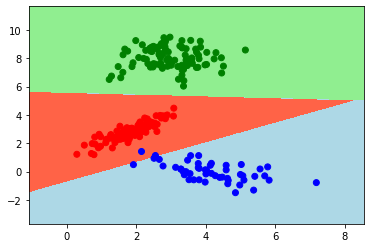

Logistic Regression


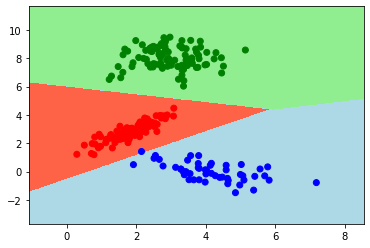

SVC


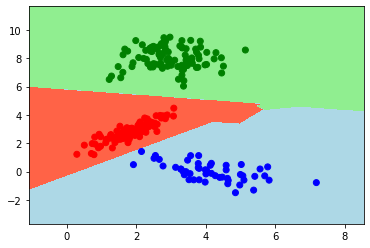

In [14]:
samp1 = (2,3,0.5,0.5,0.45)
samp2 = (4,0,1.0,0.5,-0.45)
samp3 = (3,8,0.5,0.5,0)
samps = [samp1, samp2, samp3]
print("LDA")
GenerateData_Gauss(samps, model = LinearDiscriminantAnalysis())
print("Logistic Regression")
GenerateData_Gauss(samps, model = LogisticRegression())
print("SVC")
GenerateData_Gauss(samps, model = SVC(kernel='linear'))

##### Test model 2
LDA doesn't separate the data but Logistic Regression does. This is done by exploiting LDA's property that the covariance matrices have to be the same.

LDA


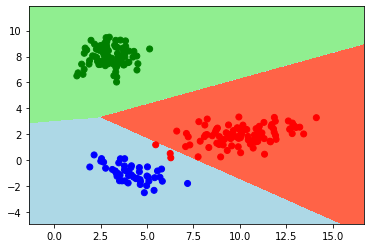

Logistic Regression


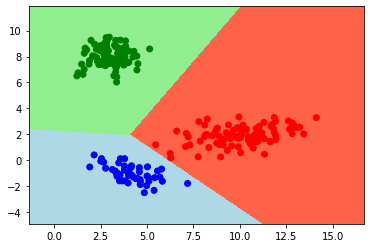

SVC


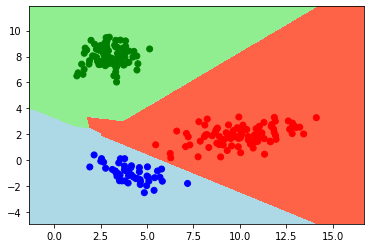

In [15]:
samp1 = (10.5,2,4,0.5,0.45)
samp2 = (4,-1,1.0,0.5,-0.45)
samp3 = (3,8,0.5,0.5,0)
samps = [samp1, samp2, samp3]
print("LDA")
GenerateData_Gauss(samps, model = LinearDiscriminantAnalysis())
print("Logistic Regression")
GenerateData_Gauss(samps, model = LogisticRegression())
print("SVC")
GenerateData_Gauss(samps, model = SVC(kernel='linear'))

----------------

-----------

### MI DATA:
1) Explain the structure of the decisions regions you find for the different classifiers

In [16]:
def GenerateData_MI(model):
    np.random.seed(1)
    midata = pd.read_csv("MI-labeled.txt", sep=',')
    features = np.array(midata[['X1','X2']])
    classlabels=midata['Class']
    labels = np.zeros(len(classlabels))
    for i in range(len(classlabels)):
        if classlabels[i] == 'I':
            labels[i]=1
    
    maxvalx = np.max(features[:,0])
    maxvaly = np.max(features[:,1])
    minvalx = np.min(features[:,0])
    minvaly = np.min(features[:,1])

    border=5 # zoom in / out: the smaller border is, the more points in the meshgrid
    xinterval = (maxvalx-minvalx)/border
    yinterval = (maxvaly-minvaly)/border
    xx, yy = np.meshgrid(np.arange(minvalx-xinterval, maxvalx+xinterval, xinterval/100), np.arange(minvaly-yinterval, maxvaly+yinterval, yinterval/100))

    prevmodel = model
    model.fit(features,labels)
    
    if (prevmodel == LinearDiscriminantAnalysis() or prevmodel == LogisticRegression()):
        
        Z=model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z=model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    
    meshclasses = np.ones(Z.size)
    meshclasses[Z<0]=0 # we use this instead because we have binary classes now!
    meshclasses = meshclasses.reshape(xx.shape)
    
    plt.contourf(xx,yy,meshclasses,[-0.1,0.1,1,2],colors=('tomato','lightblue','lightgreen'))
    plt.scatter(features[:,0],features[:,1],c=labels, cmap = mpl.colors.ListedColormap(['r', 'b','g']))
    #plt.scatter(data[:,0],data[:,1],c=classlabels_numeric, cmap = mpl.colors.ListedColormap(['r', 'b']))
    plt.show()

LDA


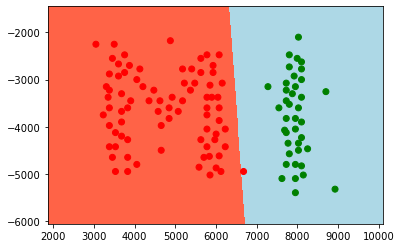

Logistic Regression


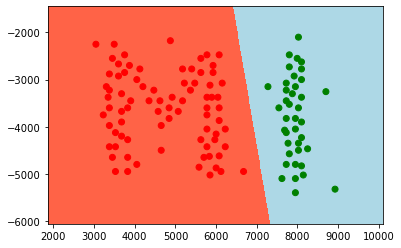

SVC


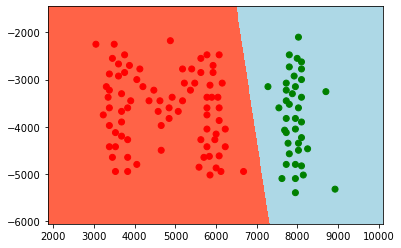

In [17]:
print("LDA")
GenerateData_MI(model = LinearDiscriminantAnalysis())
print("Logistic Regression")
GenerateData_MI(model = LogisticRegression())
print("SVC")
GenerateData_MI(model = SVC(kernel='linear'))

#### Explain the structure for each:

##### **LDA**:
LDA doesn't perfectly classify the data. This is due to the different covariance matrices, I has a much vertically prolonged covariance than M.

##### **Logistic Regression and SVC**:
They both classify perfectly and both have a strong separation, especially SVC where we see that the support vectors have been carefully chosen to separate as much as possible the data.




### Gaussian data sets in which classifier A does better in train data and classifier B does better in test data.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def GenerateData_Gauss_Acc(samps, model1, model2):
    np.random.seed(1)
    datasize=250
    mixturecoeff=np.array([0.4,0.2,0.4])
    componentsizes=(datasize*mixturecoeff).astype(int)
    
    samp1, samp2, samp3 = samps

    # sample_2d_gaussian(meanx,meany,variance_x,variance_y,covariance,numsamps)
    class0samp=sample_2d_gaussian(*samp1,componentsizes[0])
    class1samp=sample_2d_gaussian(*samp2,componentsizes[1])
    class2samp=sample_2d_gaussian(*samp3,componentsizes[2])

    features=np.concatenate((class0samp,class1samp,class2samp),axis=0)
    labels=np.concatenate((np.zeros(componentsizes[0]),np.ones(componentsizes[1]),2*np.ones(componentsizes[2])))
    
    X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = .3)
    
    prevmodel = model
    model.fit(X_train, Y_train)
    model2.fit(X_train, Y_train)
    
    if (prevmodel == LinearDiscriminantAnalysis() or prevmodel == LogisticRegression()):
        ZTr=model.predict_proba(X_train)
        ZTe=model.predict_proba(X_test)
        ZTr2=model2.predict_proba(X_train)
        ZTe2=model2.predict_proba(X_test)
    else:
        ZTr=model.decision_function(X_train)
        ZTe=model.decision_function(X_test)
        ZTr2=model2.decision_function(X_train)
        ZTe2=model2.decision_function(X_test)
        
    meshclassesTr = maxpos(ZTr)
    meshclassesTe = maxpos(ZTe)
    meshclassesTr2 = maxpos(ZTr2)
    meshclassesTe2 = maxpos(ZTe2)
    #meshclasses = np.ones(Z.size)
    #meshclasses[Z<0]=0
    
    print("Model 1:")
    print("Train accuracy: {:.3f}".format(accuracy_score(Y_train, meshclassesTr)))
    print("Test accuracy: {:.3f}".format(accuracy_score(Y_test, meshclassesTe)))
    print("Model 2:")
    print("Train accuracy: {:.3f}".format(accuracy_score(Y_train, meshclassesTr2)))
    print("Test accuracy: {:.3f}".format(accuracy_score(Y_test, meshclassesTe2)))

In [19]:
samp1 = (10.5,2,4,0.5,0.45)
samp2 = (4,-1,1.0,0.5,-0.45)
samp3 = (3,8,0.5,0.5,0)
samps = [samp1, samp2, samp3]
print("LDA")
GenerateData_Gauss_Acc(samps, LinearDiscriminantAnalysis(), LogisticRegression())

LDA
Model 1:
Train accuracy: 0.983
Test accuracy: 1.000
Model 2:
Train accuracy: 1.000
Test accuracy: 0.987


It is very possible that Logistic Regression overfit (score of 1.000) as opposed to LDA, which is less prone to overfit the data.

------------

### Part 2: the California Housing data

We next investigate some "real" data: the California housing dataset contains attributes characterizing houses in different "blocks" of California, and the median house value in these blocks. The usual machine learning problem for this dataset is the regression problem of predicting the median value. We can turn it into a binary prediction problem whether the median value is above the median (of the median values). 

The `fetch_california_housing` function returns the dataset in the form of a dictionary with attributes DESCR, data, and target.

In [20]:
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()


print(california_housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

For a first illustration, we plot the datapoints by geographic coordinates with color coded median house prices:

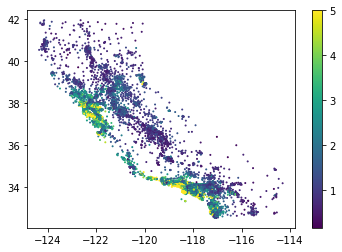

In [21]:
plt.scatter(california_housing['data'][:,7],california_housing['data'][:,6],s=1,c=california_housing['target'])
plt.colorbar()
plt.show()

We generate our binary labels, and create a train/test split:

In [22]:
labels = np.array([1 if y > np.median(california_housing['target']) else 0 for y in california_housing['target']])
features = california_housing['data']
features_train,features_test,labels_train,labels_test = train_test_split(features,labels)

After this discretization the data looks as follows (showing the full data, not train or test splits):

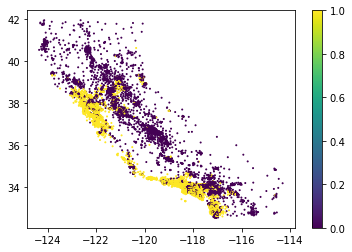

In [23]:
plt.scatter(california_housing['data'][:,7],california_housing['data'][:,6],s=1,c=labels)
plt.colorbar()
plt.show()

One can directly see that the coordinates are already pretty good predictors, though clearly not allowing for linear separbility. We investigate how good a model we get by using all features and different model classes: 

In [ ]:
# Uncomment one of the following:

#model=LinearDiscriminantAnalysis()
#model = LogisticRegression()
model = SVC(kernel='linear')

model.fit(features_train,labels_train)
pred_labels_train=model.predict(features_train)
pred_labels_test=model.predict(features_test)

print("Accuracy train: {}".format(accuracy_score(labels_train,pred_labels_train)))
print("Accuracy test: {}".format(accuracy_score(labels_test,pred_labels_test)))

**Exercise 2**: Try the different models on the California housing data. Which one is doing best in terms of test accuracy?

Inspect the following attributes of the learned models:


LDA: `means_` <br>
Logistic regression: `coef_` <br>
SVC: `coef_`<br>

Check the online documentation about the meaning of these attributes. How can the values of these attributes be used for explaining the classification model? Which of the input features are most important for the prediction? 

For this investigation it may be helpful to normalize the data before building the classifiers, using the code in the cell below (why is this useful?).



In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features_train)
features_train_norm=scaler.transform(features_train)
features_test_norm=scaler.transform(features_test)


In [28]:
model = LinearDiscriminantAnalysis()

model.fit(features_train_norm,labels_train)
pred_labels_train=model.predict(features_train_norm)
pred_labels_test=model.predict(features_test_norm)

print("Accuracy train: {}".format(accuracy_score(labels_train,pred_labels_train)))
print("Accuracy test: {}".format(accuracy_score(labels_test,pred_labels_test)))
print("Attribute: ")
print(model.means_)

Accuracy train: 0.8181524547803618
Accuracy test: 0.8153100775193799
Attribute: 
[[-0.52394936 -0.07790005 -0.08957977  0.05740961 -0.00247076  0.02118838
   0.14091399  0.04447987]
 [ 0.52057558  0.07739844  0.08900295 -0.05703994  0.00245486 -0.02105195
  -0.14000662 -0.04419346]]


LDA (LinearDiscriminantAnalysis) - means_:

means_ is an attribute in scikit-learn's LinearDiscriminantAnalysis class.

For a binary classification problem, means_ returns the mean feature values of each class.

It is a NumPy array of shape (n_classes, n_features) where n_classes represents the number of classes and n_features represents the number of input features.

Each row of means_ corresponds to the mean feature values of a particular class.

In [29]:
model = LogisticRegression()

model.fit(features_train_norm,labels_train)
pred_labels_train=model.predict(features_train_norm)
pred_labels_test=model.predict(features_test_norm)

print("Accuracy train: {}".format(accuracy_score(labels_train,pred_labels_train)))
print("Accuracy test: {}".format(accuracy_score(labels_test,pred_labels_test)))
print("Attribute: ")
print(model.coef_)

Accuracy train: 0.8266149870801034
Accuracy test: 0.8282945736434109
Attribute: 
[[ 2.47047222  0.26670888 -0.7552726   0.91508235  0.05923141 -2.09480708
  -3.65985623 -3.45116336]]


Logistic Regression - coef_:

coef_ is an attribute in scikit-learn's LogisticRegression class.

For a binary classification problem, coef_ returns the estimated coefficients or weights of the linear equation.

It is a NumPy array of shape (1, n_features) if the model is fitted with a single class or (n_classes, n_features) if it is fitted with multiple classes.

Each row of coef_ corresponds to the coefficients or weights associated with a particular class.

In [30]:
model = SVC(kernel='linear')

model.fit(features_train_norm,labels_train)
pred_labels_train=model.predict(features_train_norm)
pred_labels_test=model.predict(features_test_norm)

print("Accuracy train: {}".format(accuracy_score(labels_train,pred_labels_train)))
print("Accuracy test: {}".format(accuracy_score(labels_test,pred_labels_test)))
print("Attribute: ")
print(model.coef_)

Accuracy train: 0.8408268733850129
Accuracy test: 0.8381782945736435
Attribute: 
[[ 1.78684941  0.21814435 -0.585181    0.6712173   0.06692073 -4.72305823
  -2.75371639 -2.56001573]]


SVC (SupportVectorClassifier) - coef_:

In SVC, the coef_ attribute represents the coefficients of the support vector machine model.

It is available when the SVC model is trained with a linear kernel (kernel='linear').

For a binary classification problem, coef_ returns the weight vectors assigned to the features for each class.

It is a NumPy array of shape (n_classes-1, n_features) where n_classes represents the number of classes and n_features represents the number of input features.

Each row of coef_ corresponds to the weight vectors associated with a particular class, defining the separating hyperplane.